# Folding procedure demonstration

This Notebook is meant to demonstrate the *Folding* process that convert multi channel 1D arrays into 2D images, suitable for Semantic Segmentation Models.

## Import Dependencies

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import tensor

### Add utils to sys to import our custom scripts
**Note:** This notebook should be run from the `examples` folder to ensure the correct imports and file paths are used.

In [2]:
# Go up one level from 'examples' and point to 'utils' folder
utils_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'utils'))
# Add the 'utils' folder to sys.path
sys.path.append(utils_path)
import data_utils

### Example data paths

In [ ]:
NVCh_data = ["../data/NVCh_VT_1.npy",
            "../data/NVCh_VT_2.npy",
            "../data/NVCh_LP_1.npy",
            "../data/NVCh_LP_2.npy",
            "../data/NVCh_TR_1.npy",
            "../data/NVCh_TR_2.npy",
            "../data/NVCh_AV_1.npy",
            "../data/NVCh_AV_2.npy",
            "../data/NVCh_IC_1.npy",
            "../data/NVCh_IC_2.npy"]

### Example plot

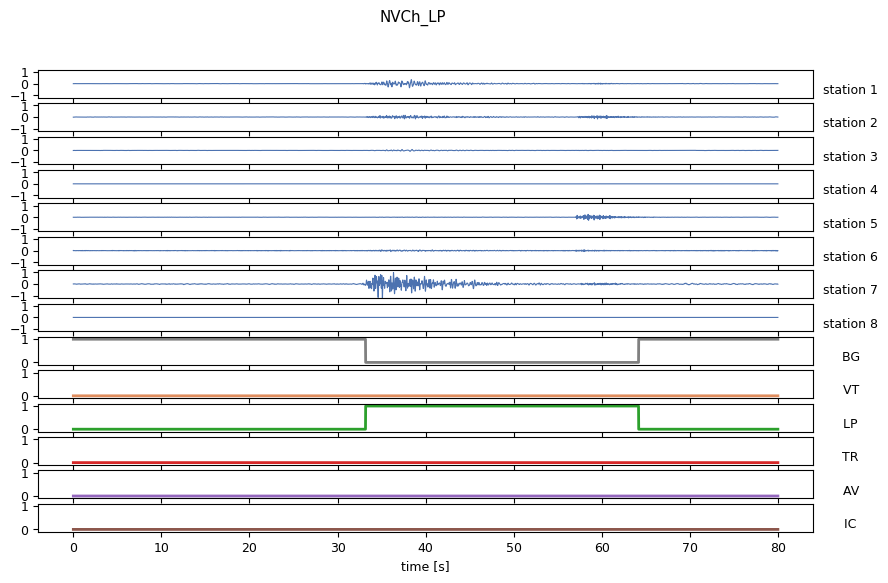

In [9]:
example_trace = np.load(NVCh_data[3])[:,:8000]
data_utils.plot_trace(example_trace,
                        n_stations=8,
                        save_path=None,
                        save=False,
                        title=NVCh_data[3][8:-6],
                        num=0,
                        dpi=100,
                        figsize=(10, 6),
                        font_size=9)

## Patch Stacking

### Multi-channel 1D signals
Our input starts as an 8x8192 array, which represents 8 stations sampled at 100Hz for a window of 81.92 seconds. The specifity of this duration is explained in the article and stems from the need to produce a 2D representation NxN so that $N=256=\sqrt{8\times 8192}$. Notice that if the original window is not exactly 8192 samples long, we can pad it to match the size (class padding is 0 for all the classes but the BG class, where it is 1).

In [41]:
original_input_signal = example_trace[:8,:]
print("original_input_signal: ", original_input_signal.shape)

# Apply padding at the start
pad_len = 8192 - example_trace.shape[1]
padded_trace = np.empty((14, 8192))
for i in range(14):
    if i == 8:
        # BG class is padded with 1's
        padded_trace[i] = np.concatenate((np.ones(pad_len), example_trace[i]))
    else:
        # everything else is apdded with 0's
        padded_trace[i] = np.concatenate((np.zeros(pad_len), example_trace[i]))

padded_input_signal = padded_trace[:8,:]
print("padded_input_signal: ", padded_input_signal.shape)

original_input_signal:  (8, 8000)
padded_input_signal:  (8, 8192)


We can visualize the array by expanding the y-axis (size 8) and compressing the x-axis (size 8192). This allows comparison to the plotted signals in the previous cells. Notice that that the padded columns are barely noticeable.

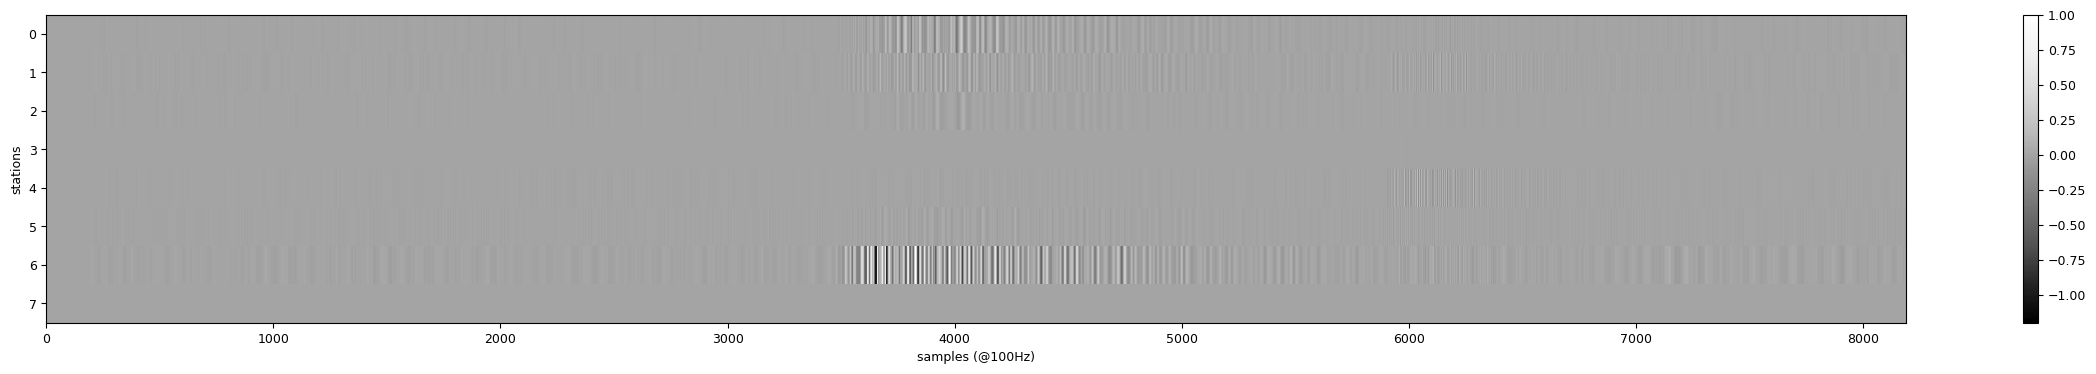

In [42]:
plt.figure(figsize=(30,4))
plt.imshow(padded_input_signal,aspect="auto", cmap="Greys_r", interpolation="nearest")
plt.xlabel("samples (@100Hz)")
plt.ylabel("stations")
plt.colorbar()
plt.show()

### Stacking of the input

To perform Patch Stacking, we use PyTorch functions:

folded_input shape:  torch.Size([1, 256, 256])


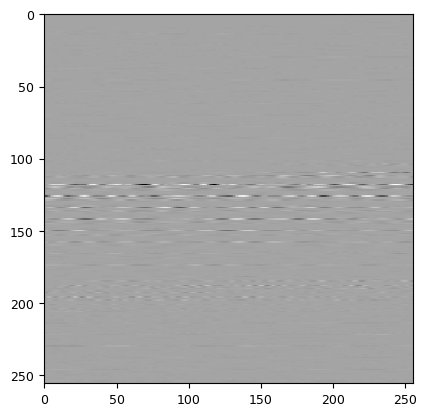

In [43]:
input_tensor = tensor(padded_input_signal)
folded_input = data_utils.fold_X(input_tensor, N=256)
print("folded_input shape: ", folded_input.shape)
plt.imshow(folded_input[0].numpy(), cmap='Greys_r', interpolation='nearest')
plt.show()

### Target Generation

We have 6 1D arrays indicating the presence of the event in time:

output_labels shape:  (6, 8192)


Text(0.5, 0, 'Samples')

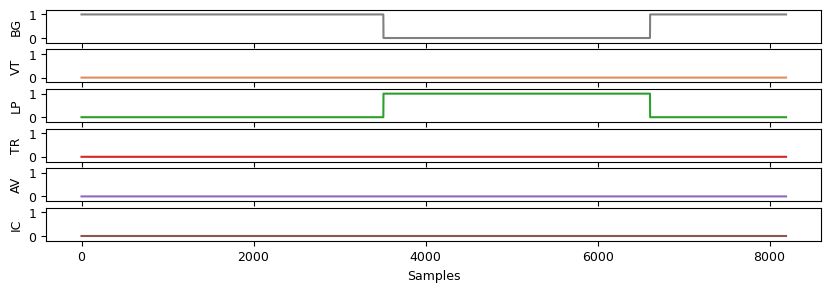

In [44]:
colors = {
    0: "#808080",
    1: "#df8d5e",
    2: "#2ca02c",
    3: "#d62728",
    4: "#9467bd",
    5: "#8c564b",
}
class_label = {
    0: "BG",
    1: "VT",
    2: "LP",
    3: "TR",
    4: "AV",
    5: "IC",
}

output_labels = padded_trace[8:,:]
print("output_labels shape: ",output_labels.shape)

fig, axes = plt.subplots(6,1,sharex=True,figsize=(10,3))
for i in range(output_labels.shape[0]):
    axes[i].plot(output_labels[i],color=colors[i])
    axes[i].set_ylim(-0.2,1.2)
    axes[i].set_ylabel(class_label[i])
axes[-1].set_xlabel("Samples")

We can see a compressed representation of the target arrays. Notice that the Background class (0) is 1 when there is no event, and 0 when an event appears. The corresponding class (in this case, 1) is set to 1 during the event's duration. The rest remain 0.

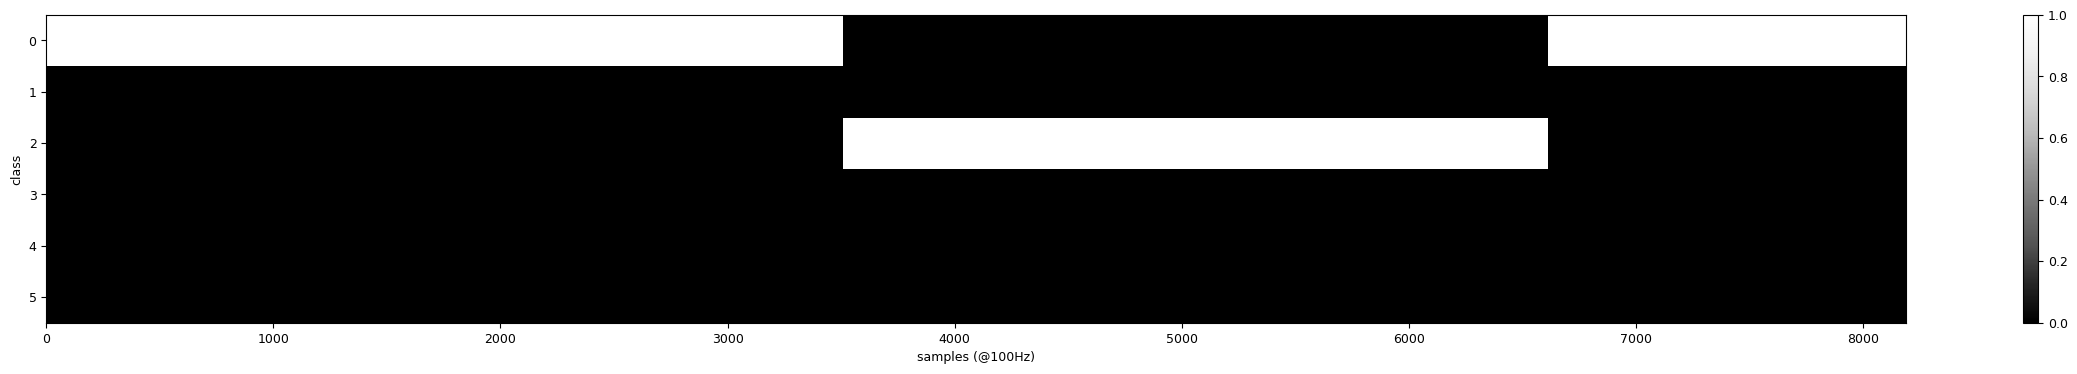

In [45]:
plt.figure(figsize=(30,4))
plt.imshow(output_labels,aspect="auto", cmap="Greys_r", interpolation="nearest")
plt.xlabel("samples (@100Hz)")
plt.ylabel("class")
plt.colorbar()
plt.show()

### Stacking the target

To train our models we require 2D targets, this is again obtained through *Patch Stacking*. The main difference here is that we generate 6 masks (one per class) and that we have to repeat our 1D label through the 8 stations (we are not interested in station-specific predictions, only time).

In [46]:
output_tensor = tensor(output_labels)
print("before repetition", output_tensor.shape)
repeated_tensor = output_tensor.unsqueeze(1).repeat(1, 8, 1) # repetition of the labels accross the 8 stations
print("after repetition", repeated_tensor.shape)

before repetition torch.Size([6, 8192])
after repetition torch.Size([6, 8, 8192])


For example, the label tensor for class 2 (LP), indicating presence of the event samples indices 3500 to 6500 approx., results in:

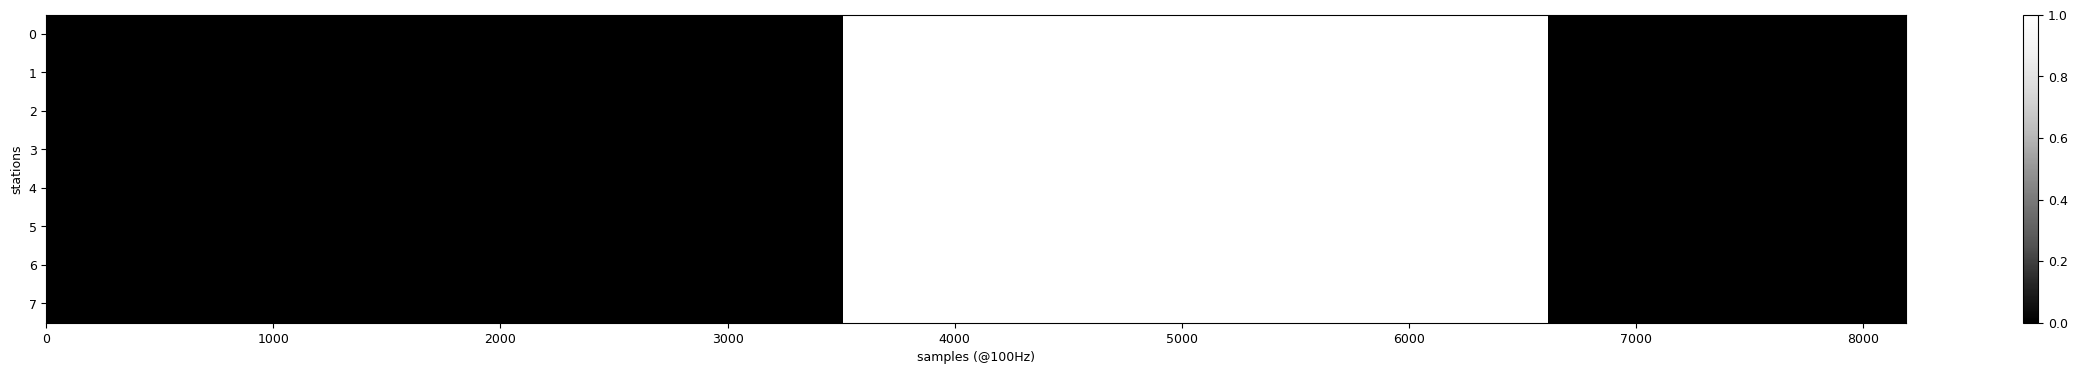

In [48]:
plt.figure(figsize=(30,4))
plt.imshow(repeated_tensor[2].numpy(),aspect="auto", cmap="Greys_r", interpolation="nearest")
plt.xlabel("samples (@100Hz)")
plt.ylabel("stations")
plt.colorbar()
plt.show()

We fold every array to obtain a 2D mask for each class, that the model has to learn:

**Note**: The function fold_y() performs the repeat procedure along the 8 stations.

In [49]:
folded_targets = data_utils.fold_y(output_tensor)
print(folded_targets.shape)

torch.Size([6, 256, 256])


We train the models using six 2D masks for each event:

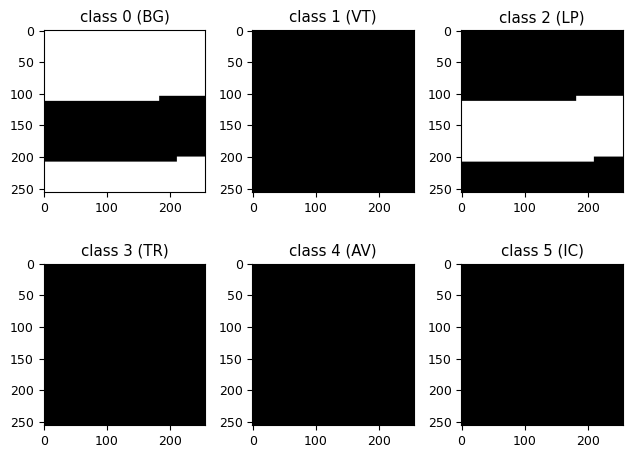

In [50]:
fig,axes = plt.subplots(2,3)
axes[0,0].imshow(folded_targets[0].numpy(),cmap='Greys_r')
axes[0,0].set_title('class 0 (BG)')
axes[0,1].imshow(folded_targets[1].numpy(),cmap='Greys_r')
axes[0,1].set_title('class 1 (VT)')
axes[0,2].imshow(folded_targets[2].numpy(),cmap='Greys_r')
axes[0,2].set_title('class 2 (LP)')
axes[1,0].imshow(folded_targets[3].numpy(),cmap='Greys_r')
axes[1,0].set_title('class 3 (TR)')
axes[1,1].imshow(folded_targets[4].numpy(),cmap='Greys_r')
axes[1,1].set_title('class 4 (AV)')
axes[1,2].imshow(folded_targets[5].numpy(),cmap='Greys_r')
axes[1,2].set_title('class 5 (IC)')
plt.tight_layout()
plt.show()